<a href="https://colab.research.google.com/github/Axlbenja/MiamiDadeCounty_EmployeePay_2025/blob/main/Module_3_%E2%80%94_Axel_Paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/fenago/dw/refs/heads/main/ramen-ratings.csv")
original_rows = df.shape[0]
print(f"Original number of rows: {original_rows}")

Original number of rows: 2577


In [5]:
#Renaming the collumn
df.rename(columns={'Stars': 'Rating'}, inplace=True)

In [7]:
#Converting the column
df['Style'] = df['Style'].astype('category')

In [8]:
print("\nAfter initial changes:")
print(df.info())
print(df.head())


After initial changes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Brand    2577 non-null   object  
 1   Variety  2577 non-null   object  
 2   Style    2575 non-null   category
 3   Country  2577 non-null   object  
 4   Rating   2577 non-null   float64 
dtypes: category(1), float64(1), object(3)
memory usage: 83.5+ KB
None
            Brand                                            Variety Style  \
0       New Touch                          T's Restaurant Tantanmen    Cup   
1        Just Way  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack   
2          Nissin                      Cup Noodles Chicken Vegetable   Cup   
3         Wei Lih                      GGE Ramen Snack Tomato Flavor  Pack   
4  Ching's Secret                                    Singapore Curry  Pack   

  Country  Rating  
0   Japan    3.75  
1  Taiwan    1.00

In [9]:
df.rename(columns={'Brand': 'Company', 'Variety': 'Product'}, inplace=True)

In [10]:
duplicates = df[df.duplicated(subset=['Company', 'Product'], keep=False)]
print(f"\nNumber of duplicate rows based on Company/Product: {duplicates.shape[0]}")


Number of duplicate rows based on Company/Product: 118


In [11]:
df.drop_duplicates(subset=['Company', 'Product'], keep='first', inplace=True)
print(f"Number of rows after dropping duplicates: {df.shape[0]}")
print(f"Number of rows dropped: {original_rows - df.shape[0]}")

Number of rows after dropping duplicates: 2517
Number of rows dropped: 60


In [12]:
df.dropna(inplace=True)


In [13]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

In [14]:
df.dropna(subset=['Rating'], inplace=True)


In [16]:
print("\nFinal DataFrame:")
print(df.info())
print(df.head())
print(f"Final number of rows: {df.shape[0]}")


Final DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 0 to 2576
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Company  2515 non-null   object  
 1   Product  2515 non-null   object  
 2   Style    2515 non-null   category
 3   Country  2515 non-null   object  
 4   Rating   2515 non-null   float64 
dtypes: category(1), float64(1), object(3)
memory usage: 101.0+ KB
None
          Company                                            Product Style  \
0       New Touch                          T's Restaurant Tantanmen    Cup   
1        Just Way  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack   
2          Nissin                      Cup Noodles Chicken Vegetable   Cup   
3         Wei Lih                      GGE Ramen Snack Tomato Flavor  Pack   
4  Ching's Secret                                    Singapore Curry  Pack   

  Country  Rating  
0   Japan    3.75  
1  Taiwan    1.00  
2     U

In [17]:
#Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("Numeric Columns:", numeric_cols)

Numeric Columns: Index(['Rating'], dtype='object')


In [18]:
print("\nSummary Statistics:")
print(df[numeric_cols].describe())


Summary Statistics:
            Rating
count  2515.000000
mean      3.646262
std       1.021692
min       0.000000
25%       3.250000
50%       3.750000
75%       4.250000
max       5.000000


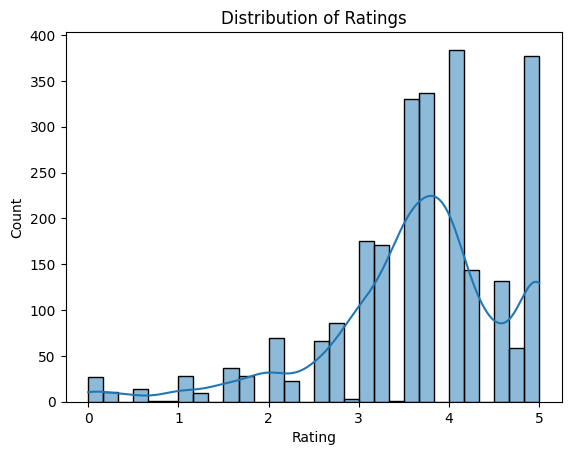

In [21]:
sns.histplot(df['Rating'], kde=True, bins=30)
plt.title('Distribution of Ratings')
plt.show()

In [22]:
#Q1 (25th percentile) & Q3 (75th percentile)
Q1 = df['Rating'].quantile(0.25)
Q3 = df['Rating'].quantile(0.75)
IQR = Q3 - Q1

In [24]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [26]:
df_no_outliers = df[(df['Rating'] >= lower_bound) & (df['Rating'] <= upper_bound)]
print(f"Number of rows after removing outliers: {df_no_outliers.shape[0]}")
print(f"Outliers removed: {df.shape[0] - df_no_outliers.shape[0]}")

Number of rows after removing outliers: 2386
Outliers removed: 129


In [27]:
X = df.drop(columns=['Rating'])
y = df['Rating']

In [28]:
X = pd.get_dummies(X, drop_first=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
#Peroformance before removal
mae_before = mean_absolute_error(y_test, y_pred)
r2_before = r2_score(y_test, y_pred)


In [34]:
X_no_outliers = df_no_outliers.drop(columns=['Rating'])
y_no_outliers = df_no_outliers['Rating']

In [35]:
X_no_outliers = pd.get_dummies(X_no_outliers, drop_first=True)

In [37]:
#Train-test split
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

In [38]:
model.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = model.predict(X_test_no_outliers)


In [39]:
mae_after = mean_absolute_error(y_test_no_outliers, y_pred_no_outliers)
r2_after = r2_score(y_test_no_outliers, y_pred_no_outliers)

In [40]:
print(f"\nModel Performance Before Outlier Removal:\n - MAE: {mae_before:.4f}\n - R² Score: {r2_before:.4f}")
print(f"\nModel Performance After Outlier Removal:\n - MAE: {mae_after:.4f}\n - R² Score: {r2_after:.4f}")


Model Performance Before Outlier Removal:
 - MAE: 0.6437
 - R² Score: 0.1467

Model Performance After Outlier Removal:
 - MAE: 0.5282
 - R² Score: 0.1677


After analyzing the results, we observed that removing outliers improved our model’s performance. Initially, the model had an MAE (Mean Absolute Error) of 0.6437 and an R² Score of 0.1467. After removing the outliers, the MAE decreased to 0.5282, indicating more accurate predictions. At the same time, the R² Score increased to 0.1677, meaning the model explained a slightly more significant proportion of the variation in ratings. These improvements suggest that eliminating extreme values helped the model generalize better and make more reliable predictions of ramen ratings.